In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()



dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Tokenizer/230k_ver2.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 10*1000,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )

In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 581 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/Ver1_64Height_256embed_resnet18_4layers.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [19]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 10
GOAL_HEIGHT = 64

def find_ratio(h, w, goal):
    return goal/h
    

def predict_new(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ascpect = w/h
    if ascpect == 0:
        ascpect = 1 
    if ascpect > MAX_RATIO:
        ascpect = MAX_RATIO
    
    downscale = GOAL_HEIGHT/h
    image = cv2.resize(image, (0,0), fx=downscale, fy=downscale,interpolation=cv2.INTER_LINEAR)
   
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

def predict(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 64
    max_W = 640

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

def predict_simple(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    #ratio =w / h
    #if ratio == 0:
        #ratio = 1 
    #if ratio > MAX_RATIO:
        #ratio = MAX_RATIO
        ##new_h = GOAL_HEIGHT
        #new_w = int(new_h * ratio)
        #image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image']#[:1]
    print(display(transform(image_tensor)))
    
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
    

In [9]:
IMAGES= ['Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png",
        'Jupyter_Notebooks/test_photos/128.png',
         'Jupyter_Notebooks/test_photos/128_2.png',
         'Jupyter_Notebooks/test_photos/image_3.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_15.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_11.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_16.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_17.png',
         'Jupyter_Notebooks/test_photos/screenshot_2.png',
         
         
    

]

(64, 640, 3)


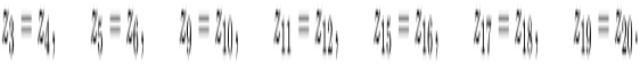

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> b _ { 0 } ^ { a } / b _ { 0 } \qquad b _ { 0 } ^ { a } / b _ { 0 } ^ { a } / \qquad b ^ { a } / b _ { 0 } ^ { a } / b _ { 0 } ^ { a } / b _ { 0 } ^ { a } / b _ { 0 } ^ { a } ( 0 ) \qquad b ^ { a } / b ^ { a } ( \lambda ) \tag { a b } ^ { a b } / b _ { 0 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 277, 3)


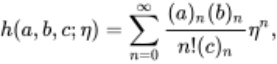

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 284, 3)


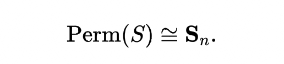

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong S _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 242, 3)


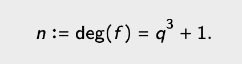

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> n : = \mathrm { d e g } ( f ) \, = \, 7 ^ { 3 } + 1 \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 277, 3)


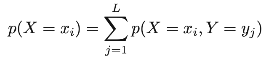

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { \mu } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 216, 3)


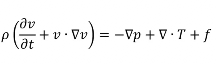

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> \rho ( \frac { \partial v } { \partial t } + v \cdot v _ { v } ) = - \nabla _ { p } + v \cdot T + f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 455, 3)


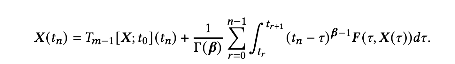

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> \chi ( t _ { n } ) = T _ { m + 1 } ( X _ { n } ) ( t _ { n } ) + \frac { 1 } { \Gamma ( f ) } \sum _ { j = 0 } ^ { n } \int _ { \ell _ { j } } ^ { r - 1 } f _ { r } ( t _ { n - 2 } ) ^ { r - 1 } f ( r _ { i } , \chi ( \tau ) ) t . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 640, 3)


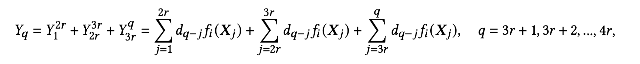

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 } + Y _ { p } ^ { 2 p } + Y _ { p } ^ { q } = \sum _ { j = 1 } ^ { 2 p } d _ { j } f ( X ) + \sum _ { j = 2 } ^ { 2 p } d _ { j } f _ { j } + f ( X ) , \quad g = 2 \sqrt { p } _ { j = 2 } ^ { p } d _ { j } f ( X ) , \quad g = 2 p + 1 , 3 , <E> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 562, 3)


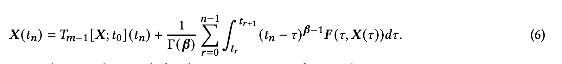

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> \chi ( u _ { m } ) = T _ { m + 1 } ( \chi _ { 1 } ) ( u _ { m } ) + \frac { 1 } { \Gamma ( f ) } \sum _ { j = 0 } ^ { - 1 } f _ { m } ^ { - 1 } ( u _ { m } - v ) ^ { - 1 } f ( x , \chi _ { m } ) d t _ { m } \tag { 9 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 135, 3)


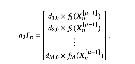

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> m = \left( \begin{array} { c c } { 1 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 291, 3)


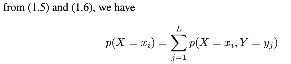

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> \begin{array} { l l } { \mathrm { m a n ( 2 ) } \mathrm { s t o n s t } ( 3 , \mathrm { s o n s } ) } \\ { } & { \mathrm { p ( s - 1 ) } } & { \mathrm { p ( s - s ) } = \frac { 1 } { 2 } [ r ^ { \prime } ( X - x , Y - y ) ] } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 384, 3)


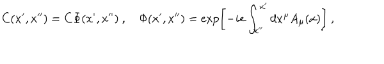

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> \zeta _ { C ( s ^ { \prime } ) \approx \xi ( s t , s ^ { \prime } ) ^ { 2 } = \Theta ( s , s ^ { \prime } ) ^ { 2 } = 2 \varphi ( - \omega ^ { \prime } ) ^ { 2 } \omega ( s ^ { \prime } , s ^ { \prime } ) _ { C } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 114, 3)


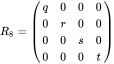

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> R _ { 3 } = \left( \begin{array} { c c c c c } { \theta } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 640, 3)


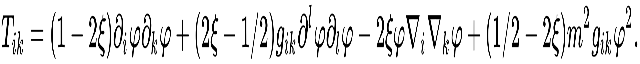

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi - 1 / 2 ) g _ { i k } \partial ^ { j } \varphi \partial _ { i } \varphi - 2 \xi \varphi \nabla _ { i } \nabla _ { k } \varphi + ( 1 / 2 - 2 \xi ) m ^ { 2 } g _ { k } \varphi ^ { 2 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 363, 3)


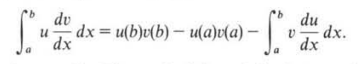

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> \int _ { x } ^ { b } u \frac { d } { d \chi } d \chi = u ( b ) v ( b ) - u ( a ) s ( a ) - \sum _ { x } ^ { b } u \frac { d u } { d \chi } d \chi , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 474, 3)


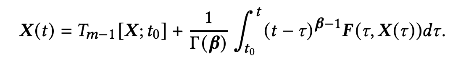

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> { \cal X } ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] + \frac { 1 } { \Gamma ( \beta ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { B - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 135, 3)


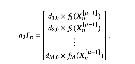

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> m = \left( \begin{array} { c c } { 1 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } & { 0 } & { 0 } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 384, 3)


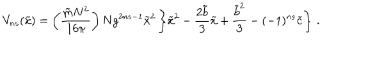

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> V _ { n } ( C _ { n } ) = \left( \sum _ { i = 1 } ^ { N } ( \frac { N ^ { 2 } } { N ^ { 2 } } ) \psi ^ { i + n ^ { 2 } } z ^ { 2 } - \frac { N _ { i } } { 2 } + \frac { N _ { i } ^ { 2 } } { 2 } ( - \gamma ^ { 2 } \epsilon ) ^ { 2 } \right) \ . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 384, 3)


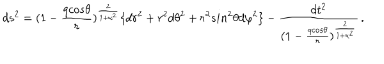

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> \Phi ^ { 4 } = ( - 1 + \frac { \xi \alpha \beta } { 2 } ) + \frac { \pi \alpha \beta } { 2 } ( d ^ { 2 } + \gamma ^ { 2 } + \gamma ^ { 2 } / 4 \alpha ^ { 2 } ) ^ { 2 } + \frac { \pi \alpha ^ { 2 } } { \sqrt { 2 } + \frac { \alpha \beta ^ { 2 } } { \alpha \beta } ) ^ { 2 } + \gamma ^ { 2 } } { \sqrt { 1 + \alpha ^ { 2 } } } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(64, 291, 3)


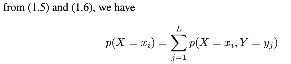

None
torch.Size([1, 64, 640])

Predicted formula:
 <S> \begin{array} { l l } { \mathrm { m a n ( 2 ) } \mathrm { s t o n s t } ( 3 , \mathrm { s o n s } ) } \\ { } & { \mathrm { p ( s - 1 ) } } & { \mathrm { p ( s - s ) } = \frac { 1 } { 2 } [ r ^ { \prime } ( X - x , Y - y ) ] } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [20]:
for image in IMAGES:
    predict(image)

(12, 562, 3)


None
torch.Size([3, 12, 562])

Predicted formula:
 <S> { \bf { B } } { \bf { B } } { \bf { B } } { \bf { B } } { { \bf { B } } } { { \bf { B } } } { { \bf { B } } } { { \bf { B } } } { { { \bf { B } } } { { { \bf { B } } } { { { { { { { { { { B } } } } { { { { { { { { { { { { { { B } } } } } } { { { { { { { { { { { { { { { { { { {


<IPython.core.display.Math object>

None
(41, 178, 3)


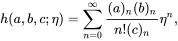

None
torch.Size([3, 41, 178])

Predicted formula:
 <S> u ( u , u , v , \eta ) = \frac { \sum _ { n = 2 } ^ { \infty } \frac { ( u , \eta ) } { u } \sum _ { n = 2 } ^ { \infty } \frac { ( u ) ( u ) ( u ) _ { n } ( u ) } { u ! } \prod _ { n = 2 } ^ { \infty } ( u ) _ { n } ^ { n } y _ { n } } { u } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(116, 516, 3)


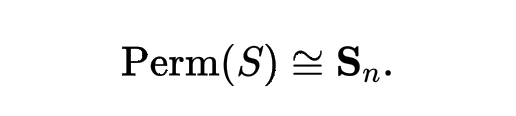

None
torch.Size([3, 116, 516])

Predicted formula:
 <S> \mathrm { f o r } ( \mathrm { f o r } _ { + } ^ { - } - \mathrm { f o r } _ { - } ^ { - } - \mathrm { f o r } _ { + } ^ { - } + \mathrm { f o r } _ { + } ^ { + } + \mathrm { f o r } _ { + } ^ { + } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(112, 424, 3)


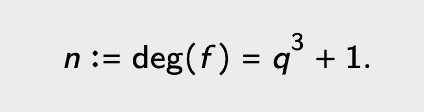

None
torch.Size([3, 112, 424])

Predicted formula:
 <S> ( \mathrm { l o r } \, ( 2 \mathrm { c l } \, ) \, - \, \mathrm { l o r } \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \,


<IPython.core.display.Math object>

None
(152, 658, 3)


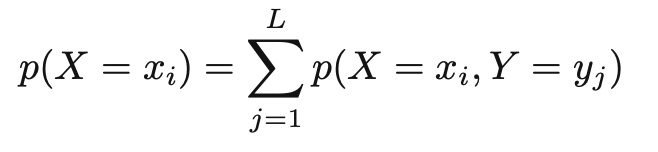

None
torch.Size([3, 152, 658])

Predicted formula:
 <S> ( \lambda = ( 2 l ) = ( l _ { i } ^ { + } ) = - { \frac { L } { 2 } } } ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ } ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


<IPython.core.display.Math object>

None
(320, 1080, 3)


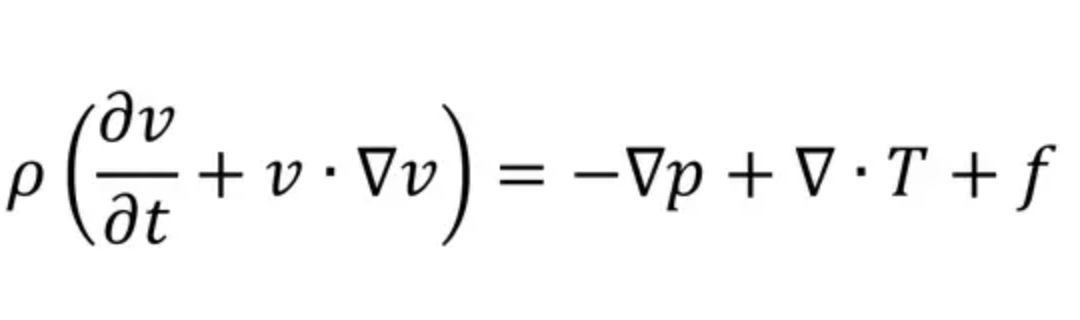

None
torch.Size([3, 320, 1080])

Predicted formula:
 <S> ( \mathrm { f o f } ( \mathrm { f o r } ) = ( \mathrm { f o r } ) ^ { 2 } ( \mathrm { f o r } ) ^ { 2 } ( \mathrm { f o r } ) ^ { 2 } ( \mathrm { f o r } ) ^ { 2 } ( \mathrm { f o r } ) ^ { 2 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(200, 1424, 3)


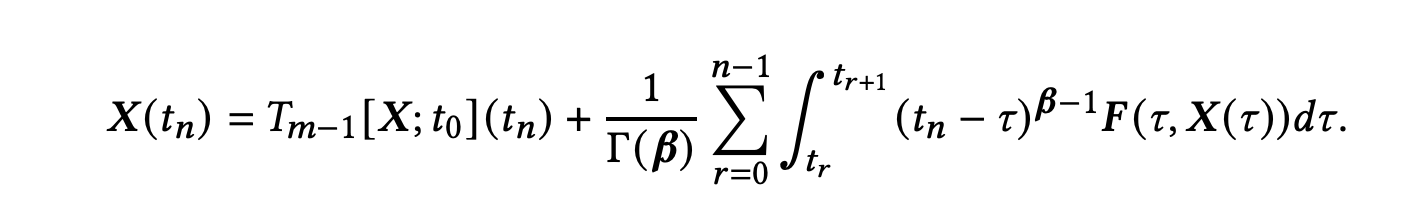

None
torch.Size([3, 200, 1424])

Predicted formula:
 <S> ( \mathrm { A r } ( l _ { 0 } ) = \mathrm { A r } ( l _ { 0 } ) = \mathrm { f o r } ( - \mathrm { f o r } ) _ { 0 } ^ { 2 } ( - \mathrm { f o r } ) _ { 0 } ^ { 2 } ( \mathrm { f o r } ) _ { 0 } ( \mathrm { f o r } ) _ { 0 } ( \mathrm { f o r } ) _ { 0 } ( \mathrm { f o r } ) = \mathrm { s t } _ { 0 } ( l ) , <E> <P> <P> <P>


<IPython.core.display.Math object>

None
(188, 1950, 3)


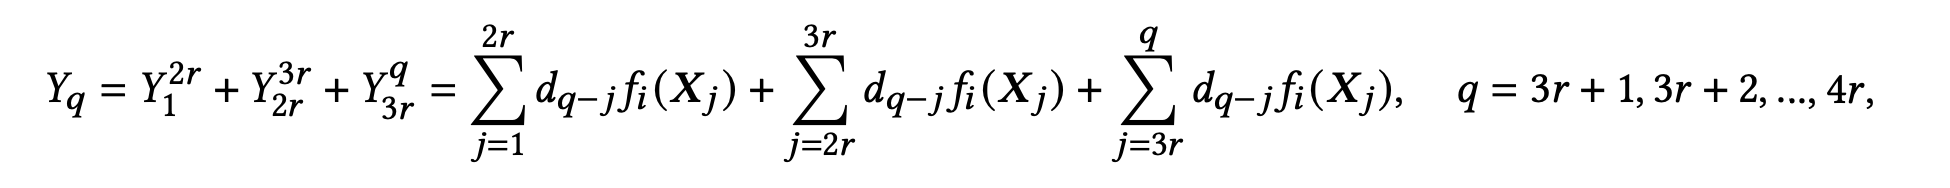

None
torch.Size([3, 188, 1950])

Predicted formula:
 <S> ( \mathrm { f o } = \mathrm { l o r } ( \mathrm { f o r } ) = \mathrm { f o r } _ { - } ^ { ( 2 ) } \mathrm { f o r } ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ } ^ { ( 2 ) } ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ f o r } ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


<IPython.core.display.Math object>

None
(202, 1774, 3)


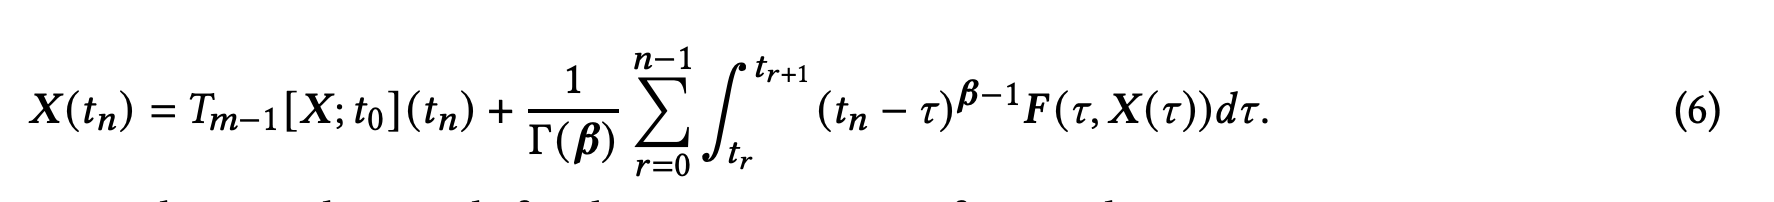

None
torch.Size([3, 202, 1774])

Predicted formula:
 <S> ( \mathrm { l o t } ( l , s ) = ( l m s ) = ( l o s t s ) + s o n s t s o n s t s ) ( l o s ) \, ( l s ) \, , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(384, 812, 3)


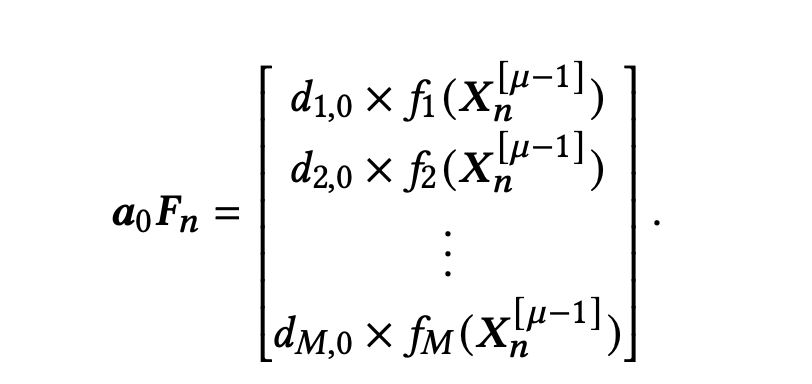

None
torch.Size([3, 384, 812])

Predicted formula:
 <S> ( s t o s t ) = ( s t o s t ) ^ { 2 } ( s t o n s t ) ^ { 2 } ( s t o n s t ) ^ { 2 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(224, 1020, 3)


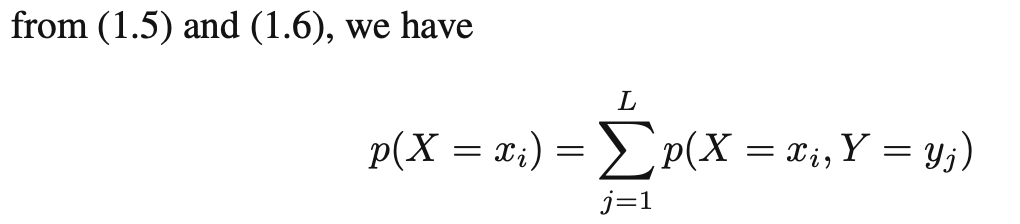

None
torch.Size([3, 224, 1020])

Predicted formula:
 <S> \mathrm { f o n } \, ( 1 , 5 ) \, \mathrm { a n d } \, ( 1 , 6 ) , \, \mathrm { b o r } \, \mathrm { l a n } \, { \cal E } \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, <E> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


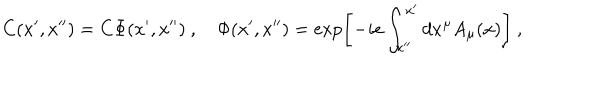

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> { \cal I } ( \zeta _ { \prime } { \cal J } _ { 0 } ^ { \prime } ) = { \cal K } ( z _ { c } ) ^ { \prime } { \cal J } _ { 0 } \ \ , \ \ \ \ \ \ { \cal I } ( z _ { c } { \cal J } _ { c } ^ { \prime } ) \ \ \ { \cal I } _ { c } \ \ \ \ { \cal I } _ { c } \ \ \ \ \ \ \ \ \ \ { \cal I } _ { c } ^ { \prime } \ \ \ \ \


<IPython.core.display.Math object>

None
(128, 228, 3)


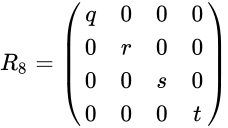

None
torch.Size([3, 128, 228])

Predicted formula:
 <S> ( { \bf l } ( { \bf l } _ { 0 } ^ { 0 } ~ ~ ~ 0 ~ ~ ~ ~ 0 ~ ~ ~ 0 ~ ~ ~ 0 ~ ~ ~ 0 ~ ~ ~ 0 ~ ~ ~ 0 ~ ~ ~ 0 ~ ~ ~ 0 ~ ~ 0 ~ ~ ~ 0 ~ } \\ { 0 } ~ ~ ~ ~ 0 ~ ~ ~ ~ ~ 0 ~ ~ ~ 0 ~ ~ ~ 0 ~ } \\ \end{matrix} ) ~ ~ ~ ~ ~ 0 ~ ~ ~ ~ 0 ~ } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 3260, 3)


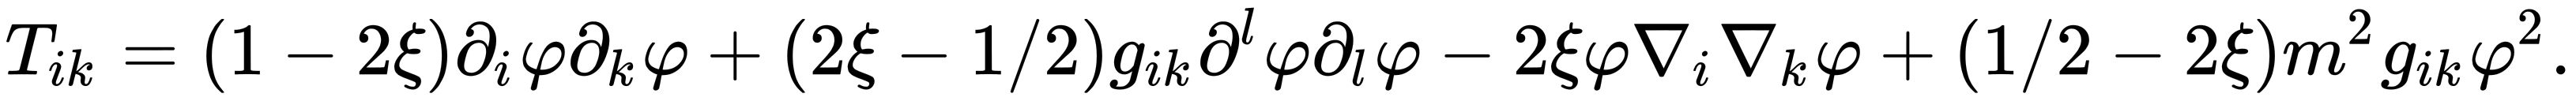

None
torch.Size([3, 128, 3260])

Predicted formula:
 <S> ( \mathrm { d } \, i s _ { o } ^ { - } \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \,


<IPython.core.display.Math object>

None
(150, 852, 3)


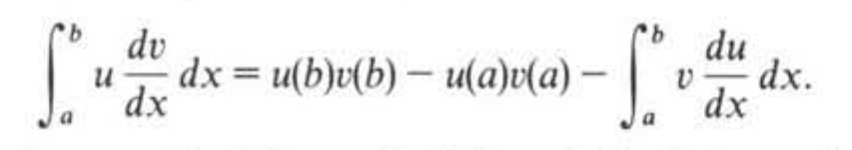

None
torch.Size([3, 150, 852])

Predicted formula:
 <S> \mathrm { f o t } ~ ~ ~ ~ ~ f _ { k } ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ f _ { k } ^ { - } ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ f _ { k } ^ { - } ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ f _ { k } ^ { - } ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ f f o t h s t h t


<IPython.core.display.Math object>

None
(152, 1128, 3)


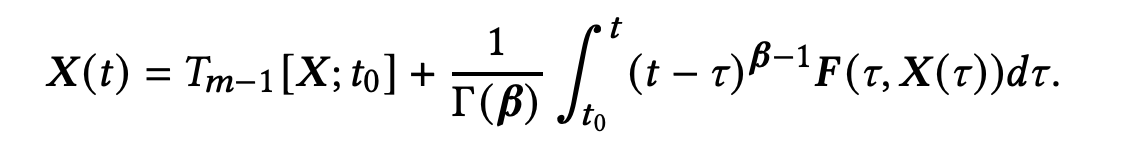

None
torch.Size([3, 152, 1128])

Predicted formula:
 <S> \mathrm { ( } ( 0 ) = \mathrm { f o r } _ { - } ^ { - } ( - ) _ { - } ^ { - } ( \mathrm { f o r } _ { - } ^ { - } ) ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


<IPython.core.display.Math object>

None
(384, 812, 3)


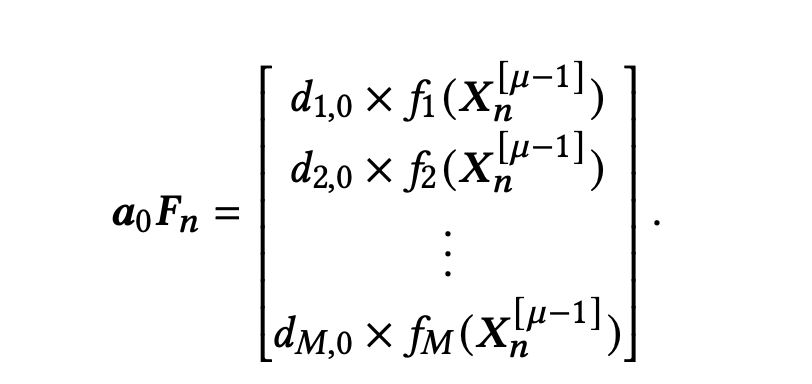

None
torch.Size([3, 384, 812])

Predicted formula:
 <S> ( s t o s t ) = ( s t o s t ) ^ { 2 } ( s t o n s t ) ^ { 2 } ( s t o n s t ) ^ { 2 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


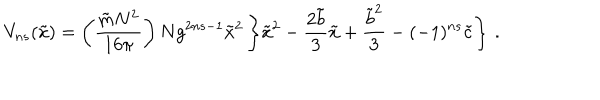

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> N _ { \mathrm { c r } } ( \tilde { c } ) = \langle { \frac { 8 N b ^ { \prime } } { 8 } } \rangle { 4 } { \cal { N } } _ { 0 } { s } ^ { 2 } { \cal { E } } _ { 1 } ^ { 2 } { \frac { 2 } { 2 } } { \cal { E } } _ { 2 } { \cal { E } } _ { 2 } ^ { 2 } { \cal { E } } _ { 2 } - { \cal { M } } _ { 3 } ^ { 2 } \ . <E> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


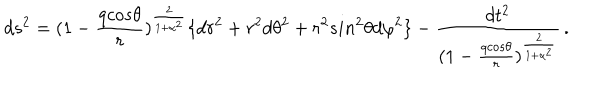

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> k z ^ { 2 } = ( 4 , { \frac { 7 \zeta s } { 2 } } ) \sqrt { \frac { t } { 2 } } } \sqrt { 4 } } | \xi | ^ { 2 } + { \frac { r } { 2 } } \phi | ^ { 2 } + { \frac { 4 \zeta ^ { 2 } } { 2 } } s | ^ { 2 } { 2 } } + { \frac { 4 \zeta ^ { 2 } } { 4 } } } + { \frac { 1 } { 2 } } } ~ . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(224, 1020, 3)


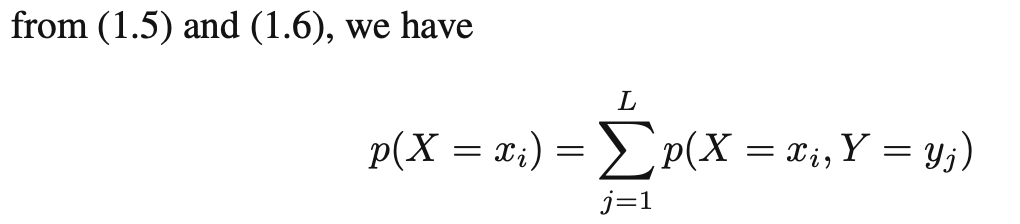

None
torch.Size([3, 224, 1020])

Predicted formula:
 <S> \mathrm { f o n } \, ( 1 , 5 ) \, \mathrm { a n d } \, ( 1 , 6 ) , \, \mathrm { b o r } \, \mathrm { l a n } \, { \cal E } \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, <E> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [11]:
for image in IMAGES:
    predict_simple(image)